# <span style="color:#0b486b">  FIT3181: Deep Learning (2024)</span>
***
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>


*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>

<br/> <br/>
School of Information Technology, Monash University, Malaysia <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
***
Surname: **CHONG**  <br/>
Firstname: **JIA YEE**    <br/>
Student ID: **33563888**    <br/>
Email: **jcho0156@student.monash.edu**    <br/>
Your tutorial time: **FRIDAY 10-12**    <br/>
***


**[Very Important]** <br/>
Make a copy of thus Google colab notebook including the traces and progresses of model training before submitting.**

## <span style="color:#0b486b">Part 2: Deep Neural Networks (DNN) </span>
<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 25 points]<span></div>

The second part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 1 to 2**. Going through these materials before attempting this assignment is highly recommended.

In the second part of this assignment, you are going to work with the FashionMNIST dataset for image recognition task. It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse, and the problem is significantly more challenging than MNIST.

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(1234)

**Load the Fashion MNIST using `torchvision`**

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset_orgin = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(train_dataset_orgin.data.shape, train_dataset_orgin.targets.shape)
print(test_dataset.data.shape, test_dataset.targets.shape)

train_dataset_orgin.data = train_dataset_orgin.data.view(-1, 28*28)
test_dataset.data = test_dataset.data.view(-1, 28*28)

print(train_dataset_orgin.data.shape, train_dataset_orgin.targets.shape)
print(test_dataset.data.shape, test_dataset.targets.shape)

N = len(train_dataset_orgin)
print(f"Number of training samples: {N}")
N_train = int(0.9*N)
N_val = N - N_train
print(f"Number of training samples: {N_train}")
print(f"Number of validation samples: {N_val}")

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_orgin, [N_train, N_val])


train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 26421880/26421880 [00:10<00:00, 2558660.26it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 159195.30it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:10<00:00, 403787.27it/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])
torch.Size([60000, 784]) torch.Size([60000])
torch.Size([10000, 784]) torch.Size([10000])
Number of training samples: 60000
Number of training samples: 54000
Number of validation samples: 6000


####  <span style="color:red">**Question 2.1:**</span> Write the code to visualize a mini-batch in `train_loader` including its images and labels.

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

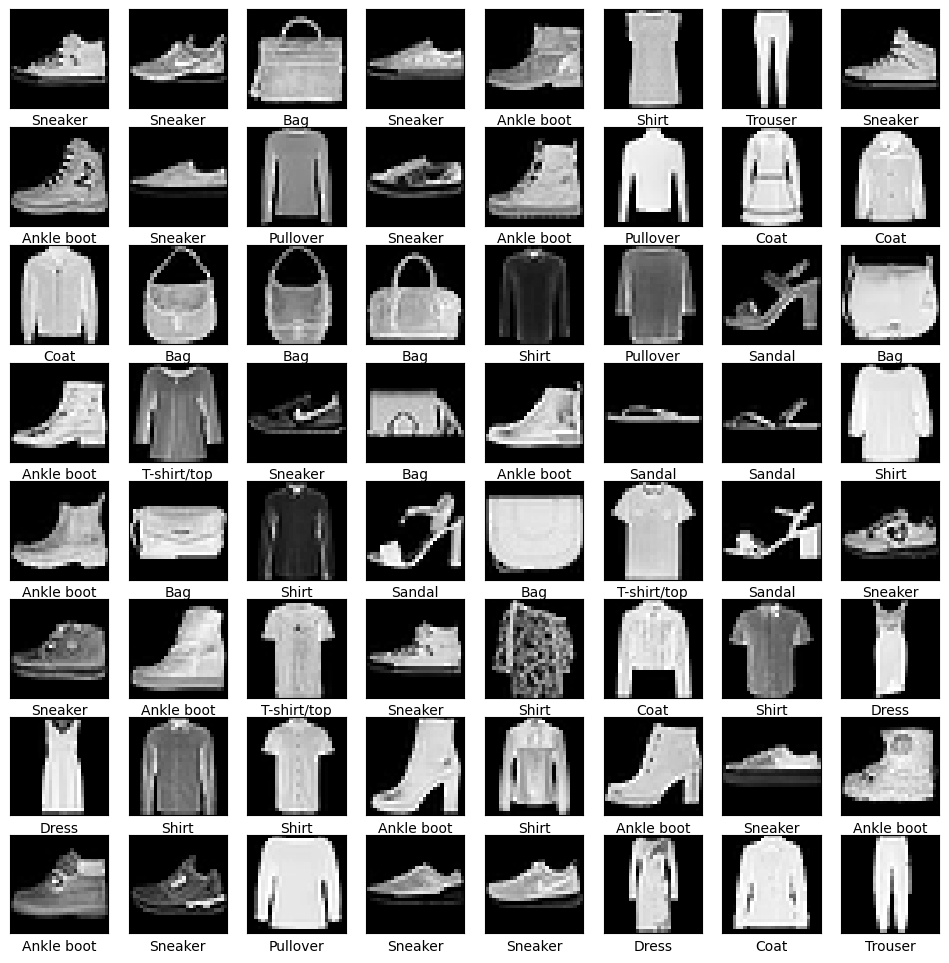

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import math

def imshow(img):
    img = img.reshape(28, 28)  # First reshape it to 28x28 for display
    plt.imshow(img, cmap='gray')  # Display the image
    
def visualize_data(images, labels, class_names, images_per_row=8):
    n_images = len(images)
    n_rows = math.ceil(float(n_images) / images_per_row)
    fig = plt.figure(figsize=(1.5 * images_per_row, 1.5 * n_rows))
    fig.patch.set_facecolor('white')
    
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        plt.xlabel(class_names[labels[i]])  # Map label index to class name
    
    plt.show()
    
# Obtain class names from the dataset
class_names = train_dataset.classes

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy for display

# Visualize the mini-batch
visualize_data(images, labels, class_names)

####<span style="color:red">**Question 2.2:**</span> Write the code for the feed-forward neural net using PyTorch

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

We now develop a feed-forward neural network with the architecture $784 \rightarrow 40(ReLU) \rightarrow 30(ReLU) \rightarrow 10(softmax)$. You can choose your own way to implement your network and an optimizer of interest. You should train model in $50$ epochs and evaluate the trained model on the test set.

In [32]:
import torch
from torch import nn, optim
import torch.nn.functional as F

# Define the Feed-Forward Neural Network (FFN)
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        # Input layer to hidden layer 1 (784 -> 40)
        self.fc1 = nn.Linear(28 * 28, 40)
        # Hidden layer 1 to hidden layer 2 (40 -> 30)
        self.fc2 = nn.Linear(40, 30)
        # Hidden layer 2 to output layer (30 -> 10)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        # Flatten the input image (batch_size, 784)
        x = x.view(-1, 28 * 28)
        # Pass through the first hidden layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Pass through the second hidden layer and apply ReLU activation
        x = F.relu(self.fc2(x))
        # Output layer: Apply softmax to get prediction probabilities
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# Create model instance
model = FashionMNISTModel()

# Define the optimizer (SGD) and loss function (cross-entropy loss)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

# Function to calculate accuracy
def calculate_accuracy(output, labels):
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)

# Function to compute loss and accuracy for a given data loader
def evaluate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in loader:
            output = model(data)
            total_loss += loss_function(output, labels).item()
            correct += (torch.max(output, 1)[1] == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

# Train the model with train and validation evaluation
def train_model(model, train_loader, valid_loader, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for data, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients from the previous iteration

            # Forward pass
            output = model(data)
            loss = loss_function(output, labels)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (torch.max(output, 1)[1] == labels).sum().item()
            total += labels.size(0)

        # Calculate training loss and accuracy
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Calculate validation loss and accuracy
        valid_loss, valid_acc = evaluate(model, valid_loader)

        # Print the results for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'train loss= {train_loss:.4f} - train acc= {train_acc * 100:.2f}% - valid loss= {valid_loss:.4f} - valid acc= {valid_acc * 100:.2f}%')

# Train the model for 30 epochs
train_model(model, train_loader, val_loader, num_epochs=30)


Epoch 1/30
train loss= 1.1447 - train acc= 60.99% - valid loss= 0.7243 - valid acc= 73.95%
Epoch 2/30
train loss= 0.6249 - train acc= 77.19% - valid loss= 0.5967 - valid acc= 78.27%
Epoch 3/30
train loss= 0.5383 - train acc= 80.61% - valid loss= 0.5398 - valid acc= 80.72%
Epoch 4/30
train loss= 0.4891 - train acc= 82.58% - valid loss= 0.5112 - valid acc= 82.00%
Epoch 5/30
train loss= 0.4584 - train acc= 83.79% - valid loss= 0.4883 - valid acc= 82.68%
Epoch 6/30
train loss= 0.4378 - train acc= 84.50% - valid loss= 0.4646 - valid acc= 83.32%
Epoch 7/30
train loss= 0.4227 - train acc= 84.98% - valid loss= 0.4503 - valid acc= 83.82%
Epoch 8/30
train loss= 0.4101 - train acc= 85.39% - valid loss= 0.4479 - valid acc= 84.15%
Epoch 9/30
train loss= 0.4011 - train acc= 85.77% - valid loss= 0.4348 - valid acc= 84.40%
Epoch 10/30
train loss= 0.3923 - train acc= 86.01% - valid loss= 0.4303 - valid acc= 84.82%
Epoch 11/30
train loss= 0.3854 - train acc= 86.18% - valid loss= 0.4218 - valid acc= 84.8

####  <span style="color:red">**Question 2.3:**</span> Tuning hyper-parameters with grid search
<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>


Assume that you need to tune the number of neurons on the first and second hidden layers $n_1 \in \{20, 40\}$, $n_2 \in \{20, 40\}$  and the used activation function  $act \in \{sigmoid, tanh, relu\}$. The network has the architecture pattern $784 \rightarrow n_1 (act) \rightarrow n_2(act) \rightarrow 10(softmax)$ where $n_1, n_2$, and $act$ are in their grides. Write the code to tune the hyper-parameters $n_1, n_2$, and $act$. Note that you can freely choose the optimizer and learning rate of interest for this task.

In [33]:
#Your code here
import torch
from torch import nn, optim
import torch.nn.functional as F
from itertools import product

# Define the feed-forward neural network with variable hidden layers and activation functions
class FashionMNISTModel(nn.Module):
    def __init__(self, n1, n2, activation_fn):
        super(FashionMNISTModel, self).__init__()
        # Input layer to hidden layer 1 (784 -> n1)
        self.fc1 = nn.Linear(28 * 28, n1)
        # Hidden layer 1 to hidden layer 2 (n1 -> n2)
        self.fc2 = nn.Linear(n1, n2)
        # Hidden layer 2 to output layer (n2 -> 10)
        self.fc3 = nn.Linear(n2, 10)
        # Store the chosen activation function
        self.activation_fn = activation_fn

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image (batch_size, 784)
        x = self.activation_fn(self.fc1(x))  # Apply activation after first hidden layer
        x = self.activation_fn(self.fc2(x))  # Apply activation after second hidden layer
        x = F.log_softmax(self.fc3(x), dim=1)  # Output layer: Apply softmax to get prediction probabilities
        return x

# Function to train a model with specific hyperparameters
def train_and_evaluate(n1, n2, activation_fn, train_loader, valid_loader, num_epochs=20):
    # Create model with the specified hyperparameters
    model = FashionMNISTModel(n1, n2, activation_fn)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()

    # After training, evaluate the model on the validation set
    valid_loss, valid_acc = evaluate(model, valid_loader)
    return valid_acc

# Hyperparameter values for grid search
n1_values = [20, 40]
n2_values = [20, 40]
activation_functions = [F.sigmoid, F.tanh, F.relu]  # You can also use nn.Sigmoid(), nn.Tanh(), nn.ReLU()

# Perform grid search over all combinations of n1, n2, and activation function
best_acc = 0
best_params = None

for n1, n2, activation_fn in product(n1_values, n2_values, activation_functions):
    print(f'Training model with n1={n1}, n2={n2}, activation_fn={activation_fn.__name__}')
    val_acc = train_and_evaluate(n1, n2, activation_fn, train_loader, val_loader, num_epochs=20)
    print(f'Validation accuracy: {val_acc * 100:.2f}%')

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (n1, n2, activation_fn.__name__, best_acc)

print(f'Best validation accuracy: {best_acc * 100:.2f}%')
print(f'Best hyperparameters: n1={best_params[0]}, n2={best_params[1]}, activation_fn={best_params[2]}, accuracy={best_params[3] * 100:.2f}%')



Training model with n1=20, n2=20, activation_fn=sigmoid
Validation accuracy: 60.33%
Training model with n1=20, n2=20, activation_fn=tanh
Validation accuracy: 84.98%
Training model with n1=20, n2=20, activation_fn=relu
Validation accuracy: 84.38%
Training model with n1=20, n2=40, activation_fn=sigmoid
Validation accuracy: 62.97%
Training model with n1=20, n2=40, activation_fn=tanh
Validation accuracy: 84.93%
Training model with n1=20, n2=40, activation_fn=relu
Validation accuracy: 84.13%
Training model with n1=40, n2=20, activation_fn=sigmoid
Validation accuracy: 66.42%
Training model with n1=40, n2=20, activation_fn=tanh
Validation accuracy: 84.62%
Training model with n1=40, n2=20, activation_fn=relu
Validation accuracy: 84.40%
Training model with n1=40, n2=40, activation_fn=sigmoid
Validation accuracy: 66.57%
Training model with n1=40, n2=40, activation_fn=tanh
Validation accuracy: 85.28%
Training model with n1=40, n2=40, activation_fn=relu
Validation accuracy: 84.37%
Best validation 

####  <span style="color:red">**Question 2.4:**</span> Implement the loss with the form: $loss(p,y)=CE(1_{y},p)+\lambda H(p)$ where $H(p)=-\sum_{i=1}^{M}p_{i}\log p_{i}$ is the entropy of $p$, $p$ is the prediction probabilities of a data point $x$ with the ground-truth label $y$, $1_y$ is an one-hot label, and $\lambda >0$ is a trade-off parameter. Set $\lambda = 0.1$ to train a model.

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>


In [34]:
#Your code here

import torch
import torch.nn.functional as F

# Custom loss function
class CustomLoss(nn.Module):
    def __init__(self, lambda_param=0.1):
        super(CustomLoss, self).__init__()
        self.lambda_param = lambda_param

    def forward(self, output, target):
        # Cross-Entropy Loss (CE)
        ce_loss = F.cross_entropy(output, target)

        # Entropy term H(p)
        probs = F.softmax(output, dim=1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1).mean()

        # Total loss = CE + λ * H(p)
        total_loss = ce_loss + self.lambda_param * entropy
        return total_loss

# Define your model again
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# Create model instance
model = FashionMNISTModel()

# Define optimizer and custom loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_function = CustomLoss(lambda_param=0.1)

# Training function using custom loss
def train_model_custom_loss(model, train_loader, valid_loader, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for data, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients from the previous iteration

            # Forward pass
            output = model(data)
            loss = loss_function(output, labels)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (torch.max(output, 1)[1] == labels).sum().item()
            total += labels.size(0)

        # Calculate training loss and accuracy
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Calculate validation loss and accuracy
        valid_loss, valid_acc = evaluate(model, valid_loader)

        # Print the results for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'train loss= {train_loss:.4f} - train acc= {train_acc * 100:.2f}% - valid loss= {valid_loss:.4f} - valid acc= {valid_acc * 100:.2f}%')

# Train the model for 30 epochs with the custom loss
train_model_custom_loss(model, train_loader, val_loader, num_epochs=30)


Epoch 1/30
train loss= 1.2059 - train acc= 64.15% - valid loss= 0.7316 - valid acc= 75.53%
Epoch 2/30
train loss= 0.6288 - train acc= 79.29% - valid loss= 0.6400 - valid acc= 78.35%
Epoch 3/30
train loss= 0.5523 - train acc= 82.10% - valid loss= 0.5801 - valid acc= 80.92%
Epoch 4/30
train loss= 0.5172 - train acc= 83.27% - valid loss= 0.5479 - valid acc= 82.12%
Epoch 5/30
train loss= 0.4927 - train acc= 83.97% - valid loss= 0.5278 - valid acc= 82.78%
Epoch 6/30
train loss= 0.4739 - train acc= 84.61% - valid loss= 0.5036 - valid acc= 83.57%
Epoch 7/30
train loss= 0.4594 - train acc= 85.02% - valid loss= 0.5088 - valid acc= 83.75%
Epoch 8/30
train loss= 0.4464 - train acc= 85.43% - valid loss= 0.4968 - valid acc= 84.43%
Epoch 9/30
train loss= 0.4352 - train acc= 85.89% - valid loss= 0.4859 - valid acc= 84.32%
Epoch 10/30
train loss= 0.4258 - train acc= 86.10% - valid loss= 0.4627 - valid acc= 84.92%
Epoch 11/30
train loss= 0.4161 - train acc= 86.43% - valid loss= 0.4662 - valid acc= 84.7

####  <span style="color:red">**Question 2.5:**</span> Experimenting with **sharpness-aware minimization** technique
<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

Sharpness-aware minimization (SAM) (i.e., [link for main paper](https://openreview.net/pdf?id=6Tm1mposlrM) from Google Deepmind) is a simple yet but efficient technique to improve the generalization ability of deep learning models on unseen data examples. In your research or your work, you might potentially use this idea. Your task is to read the paper and implement *Sharpness-aware minimization (SAM)*. Finally, you need to apply SAM to the best architecture found in **Question 2.3**.   

In [35]:
#Your code here

import torch
from torch.optim import Optimizer

class SAM(Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        # Initialize the base optimizer (e.g., SGD, Adam)
        defaults = dict(rho=rho, **kwargs)
        self.base_optimizer = base_optimizer(params, **kwargs)
        super(SAM, self).__init__(params, defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        # Step 1: Save current weights and perturb them
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group['rho'] / (grad_norm + 1e-12)
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['old_p'] = p.data.clone()
                p.add_(p.grad * scale)  # Perturb the parameters
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        # Step 2: Restore the original weights and update with the base optimizer
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.data = self.state[p]['old_p']  # Restore the original parameters
        self.base_optimizer.step()  # Perform optimization step
        if zero_grad:
            self.zero_grad()

    def _grad_norm(self):
        # Calculate the norm of the gradients across all parameters
        shared_device = self.param_groups[0]['params'][0].device
        norm = torch.norm(torch.stack([
            torch.norm(p.grad.detach(), 2).to(shared_device)
            for group in self.param_groups for p in group['params']
            if p.grad is not None
        ]), 2)
        return norm

    @torch.no_grad()
    def step(self, closure=None):
        # This function defines the SAM update process
        assert closure is not None, "SAM requires closure, but it was not provided"
        # First forward-backward step
        closure()  # Compute loss and gradients
        self.first_step(zero_grad=True)
        # Second forward-backward step with perturbed weights
        closure()  # Compute loss and gradients
        self.second_step(zero_grad=True)

    def zero_grad(self):
        self.base_optimizer.zero_grad()



In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from itertools import product

# Define the feed-forward neural network with variable hidden layers and activation functions
class FashionMNISTModel(nn.Module):
    def __init__(self, n1, n2, activation_fn):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, 10)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# Train and evaluate using SAM
def train_and_evaluate_with_sam(n1, n2, activation_fn, train_loader, valid_loader, num_epochs=10):
    model = FashionMNISTModel(n1, n2, activation_fn)
    base_optimizer = optim.SGD  # Base optimizer
    optimizer = SAM(model.parameters(), base_optimizer, lr=0.01, rho=0.05)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = loss_function(output, labels)
                loss.backward()
                return loss

            optimizer.step(closure)  # Apply SAM's two-step process

    # Evaluate on validation set after training
    valid_loss, valid_acc = evaluate(model, valid_loader)
    return valid_acc

# Hyperparameters for grid search (same as before)
n1_values = [20, 40]
n2_values = [20, 40]
activation_functions = [F.sigmoid, F.tanh, F.relu]

# Perform grid search with SAM
best_acc = 0
best_params = None

for n1, n2, activation_fn in product(n1_values, n2_values, activation_functions):
    print(f'Training model with n1={n1}, n2={n2}, activation_fn={activation_fn.__name__} using SAM')
    val_acc = train_and_evaluate_with_sam(n1, n2, activation_fn, train_loader, val_loader, num_epochs=10)
    print(f'Validation accuracy: {val_acc * 100:.2f}%')

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (n1, n2, activation_fn.__name__)

print(f'Best validation accuracy: {best_acc * 100:.2f}%')
print(f'Best hyperparameters: n1={best_params[0]}, n2={best_params[1]}, activation_fn={best_params[2]}')
